## Phase 3 — Modeling + Explainability + Drift checks (Trigger Emulation)

**Input:**  
Parquet shards produced in Phase 2 (`/kaggle/working/parquet_dimuon/`)

**Output:**

- A baseline model to emulate one HLT path (start with the balanced one)
- Proper evaluation with grouped splits by event (no leakage)
- Explainability (feature importance + SHAP if available)
- Stability/drift plots vs run and lumi
- Saved model + metrics + figures


In [10]:
# Cell 1 — Install deps
!pip -q install lightgbm scikit-learn shap pyarrow fastparquet matplotlib seaborn


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.8/1.8 MB 67.4 MB/s eta 0:00:00


In [11]:
# Cell 2 — Imports & config
from pathlib import Path
import glob
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score, average_precision_score, precision_recall_curve, roc_curve

import lightgbm as lgb

SEED = 42
np.random.seed(SEED)

PARQUET_DIR = Path("/kaggle/input/datasets/katakuricharlotte/parquet-triggeremu/parquet_dimuon")
parquet_files = sorted(glob.glob(str(PARQUET_DIR / "*.parquet")))

len(parquet_files), parquet_files[:3]


(1,
 ['/kaggle/input/datasets/katakuricharlotte/parquet-triggeremu/parquet_dimuon/dimuon_shard_000.parquet'])

In [12]:
# Cell 3 — Load Parquet (start small; scale later)
# If you only produced one shard, this still works.
MAX_FILES = 5  # increase later
use_files = parquet_files[:MAX_FILES]

df = pd.concat([pd.read_parquet(p) for p in use_files], ignore_index=True)
df.shape, df.columns.tolist()[:30]


((1378545, 12),
 ['run',
  'lumi',
  'event',
  'm_mumu',
  'pt_mumu',
  'eta_mumu',
  'dR_mumu',
  'PV_npvs',
  'MET_pt',
  'HLT_Mu17_Mu8',
  'HLT_Mu17_Mu8_DZ',
  'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'])

In [13]:
# Cell 4 — Sanity checks (schema, missingness, duplicates)
print(df.dtypes.head(20))
display(df.head(5))

# Missing values summary (top)
na = df.isna().mean().sort_values(ascending=False)
na.head(20)


run                                     uint32
lumi                                    uint32
event                                   uint64
m_mumu                                 float32
pt_mumu                                float32
eta_mumu                               float32
dR_mumu                                float32
PV_npvs                                  int32
MET_pt                                 float32
HLT_Mu17_Mu8                              int8
HLT_Mu17_Mu8_DZ                           int8
HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ       int8
dtype: object


,run,lumi,event,m_mumu,pt_mumu,eta_mumu,dR_mumu,PV_npvs,MET_pt,HLT_Mu17_Mu8,HLT_Mu17_Mu8_DZ,HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ
0,278822,951,1657783742,0.717688,27.446304,0.381257,0.051071,12,27.271524,0,0,0
1,278822,951,1657783742,17.536045,5.466623,1.782907,3.233651,12,27.271524,0,0,0
2,278822,951,1658163927,0.328497,31.051395,-1.633330,0.008130,10,24.150330,0,0,1
3,278822,951,1658163927,15.175849,15.982114,-1.596437,2.230811,10,24.150330,0,0,1
4,278822,951,1658526011,19.699652,39.251945,-0.040246,0.976195,19,29.609695,0,0,1


run                                    0.0
lumi                                   0.0
event                                  0.0
m_mumu                                 0.0
pt_mumu                                0.0
eta_mumu                               0.0
dR_mumu                                0.0
PV_npvs                                0.0
MET_pt                                 0.0
HLT_Mu17_Mu8                           0.0
HLT_Mu17_Mu8_DZ                        0.0
HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ    0.0
dtype: float64

In [14]:
# Cell 5 — Ensure labels exist and inspect label rates
LABELS = [c for c in df.columns if c.startswith("HLT_")]
LABELS[:10], len(LABELS)


(['HLT_Mu17_Mu8', 'HLT_Mu17_Mu8_DZ', 'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ'], 3)

In [15]:
# Cell 6 — Pick a primary label (balanced one first)
# From your output: HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ ~ 0.45, others ~ 0.02
TARGET = "HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ" if "HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ" in df.columns else LABELS[0]
y = df[TARGET].astype(int)

y.mean(), TARGET


(np.float64(0.4522601728634176), 'HLT_Mu17_TrkIsoVVL_Mu8_TrkIsoVVL_DZ')

In [16]:
# Cell 7 — Build event groups to avoid leakage
# IMPORTANT: your rows are dimuon pairs; multiple rows share same (run,lumi,event).
# We'll group-split by a stable event_id.
df["event_id"] = df["run"].astype(str) + ":" + df["lumi"].astype(str) + ":" + df["event"].astype(str)
groups = df["event_id"].values

df["event_id"].nunique(), len(df)


(1171442, 1378545)

In [17]:
# Cell 8 — Define feature set (explainable, physics-friendly)
# Keep only engineered dimuon + simple event context; avoid labels and identifiers.
drop_cols = set(["run", "lumi", "event", "event_id"]) | set(LABELS)
candidate_features = [c for c in df.columns if c not in drop_cols]

# LightGBM can't handle object; enforce numeric
X = df[candidate_features].copy()
for c in X.columns:
    if X[c].dtype == "object":
        X[c] = pd.to_numeric(X[c], errors="coerce")

# Basic imputation: fill NaNs with median (simple + explainable baseline)
X = X.fillna(X.median(numeric_only=True))

X.shape, X.columns.tolist()


((1378545, 6),
 ['m_mumu', 'pt_mumu', 'eta_mumu', 'dR_mumu', 'PV_npvs', 'MET_pt'])

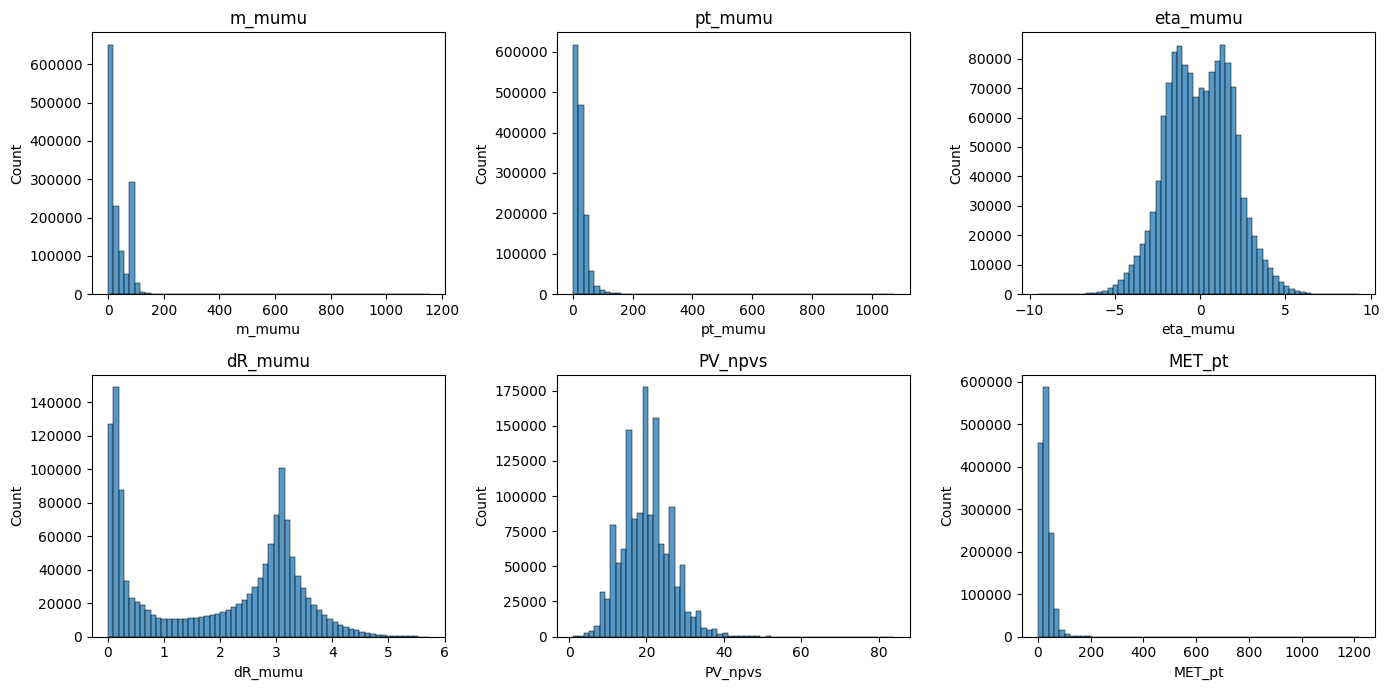

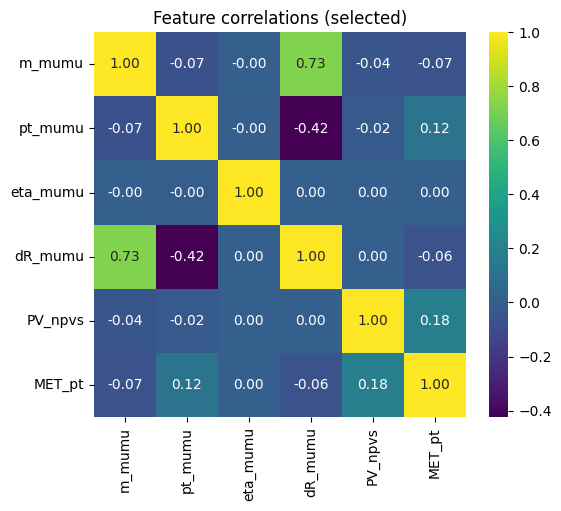

In [18]:
# Cell 9 — Quick EDA of key features (distributions + correlations)
key_feats = [c for c in ["m_mumu", "pt_mumu", "eta_mumu", "dR_mumu", "PV_npvs", "MET_pt"] if c in X.columns]

fig, axes = plt.subplots(2, 3, figsize=(14, 7))
axes = axes.ravel()
for i, c in enumerate(key_feats[:6]):
    sns.histplot(X[c], bins=60, ax=axes[i], kde=False)
    axes[i].set_title(c)
plt.tight_layout()
plt.show()

# Correlation heatmap (small set)
if len(key_feats) >= 2:
    plt.figure(figsize=(6,5))
    sns.heatmap(pd.DataFrame(X[key_feats]).corr(), annot=True, fmt=".2f", cmap="viridis")
    plt.title("Feature correlations (selected)")
    plt.show()


In [19]:
# Cell 10 — Define evaluation helpers
def eval_fold(y_true, y_score):
    out = {}
    out["roc_auc"] = roc_auc_score(y_true, y_score)
    out["ap"] = average_precision_score(y_true, y_score)
    return out

def plot_curves(y_true, y_score, title_suffix=""):
    fpr, tpr, _ = roc_curve(y_true, y_score)
    prec, rec, _ = precision_recall_curve(y_true, y_score)

    plt.figure(figsize=(6,5))
    plt.plot(fpr, tpr)
    plt.plot([0,1],[0,1], "--", alpha=0.5)
    plt.xlabel("FPR"); plt.ylabel("TPR")
    plt.title(f"ROC {title_suffix}")
    plt.show()

    plt.figure(figsize=(6,5))
    plt.plot(rec, prec)
    plt.xlabel("Recall"); plt.ylabel("Precision")
    plt.title(f"PR {title_suffix}")
    plt.show()


In [20]:
# Cell 11 — GroupKFold training (no leakage)
# GroupKFold enforces that the same event_id never appears in both train and val. [web:141]
gkf = GroupKFold(n_splits=5)

params = dict(
    n_estimators=400,
    learning_rate=0.05,
    num_leaves=31,
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=SEED,
    n_jobs=-1
)

fold_metrics = []
oof = np.zeros(len(df), dtype=float)

for fold, (tr_idx, va_idx) in enumerate(gkf.split(X, y, groups=groups), start=1):
    X_tr, X_va = X.iloc[tr_idx], X.iloc[va_idx]
    y_tr, y_va = y.iloc[tr_idx], y.iloc[va_idx]

    # Handle imbalance: LightGBM suggests scale_pos_weight or is_unbalance for binary. [web:152]
    pos = max(y_tr.sum(), 1)
    neg = max((len(y_tr) - y_tr.sum()), 1)
    spw = neg / pos

    clf = lgb.LGBMClassifier(
        objective="binary",
        scale_pos_weight=spw,
        **params
    )
    clf.fit(X_tr, y_tr)

    yhat = clf.predict_proba(X_va)[:, 1]
    oof[va_idx] = yhat

    m = eval_fold(y_va, yhat)
    m["fold"] = fold
    m["scale_pos_weight"] = spw
    fold_metrics.append(m)
    print(f"Fold {fold}:", m)

metrics_df = pd.DataFrame(fold_metrics)
metrics_df, metrics_df[["roc_auc","ap"]].mean()


[LightGBM] [Info] Number of positive: 498513, number of negative: 604323
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.015208 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1335
[LightGBM] [Info] Number of data points in the train set: 1102836, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452028 -> initscore=-0.192479
[LightGBM] [Info] Start training from score -0.192479
Fold 1: {'roc_auc': np.float64(0.8562325493048744), 'ap': np.float64(0.8058099527465927), 'fold': 1, 'scale_pos_weight': np.float64(1.2122512351734056)}
[LightGBM] [Info] Number of positive: 498572, number of negative: 604264
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.031899 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info]

(    roc_auc        ap  fold  scale_pos_weight
 0  0.856233  0.805810     1          1.212251
 1  0.855537  0.803742     2          1.211989
 2  0.857020  0.806711     3          1.211839
 3  0.856090  0.804331     4          1.210358
 4  0.858293  0.805606     5          1.209149,
 roc_auc    0.856634
 ap         0.805240
 dtype: float64)

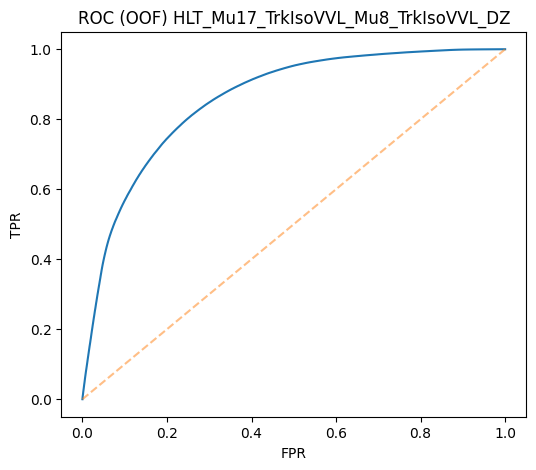

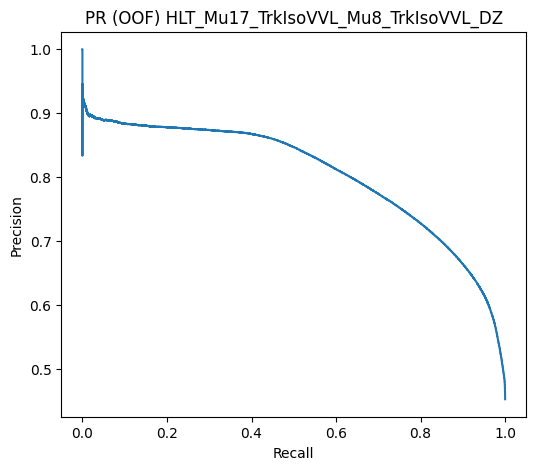

OOF ROC-AUC: 0.8566293784039053
OOF AP: 0.8052162731840997


In [21]:
# Cell 12 — OOF curves
plot_curves(y, oof, title_suffix=f"(OOF) {TARGET}")
print("OOF ROC-AUC:", roc_auc_score(y, oof))
print("OOF AP:", average_precision_score(y, oof))  # AP summarizes PR curve. [web:150]


In [ ]:
# Cell 13 — Feature importance (explainable baseline)
# Train final model on all data (for importance + saving)
pos = max(y.sum(), 1)
neg = max((len(y) - y.sum()), 1)
spw = neg / pos

final_model = lgb.LGBMClassifier(objective="binary", scale_pos_weight=spw, **params)
final_model.fit(X, y)

imp = pd.DataFrame({
    "feature": X.columns,
    "importance": final_model.feature_importances_
}).sort_values("importance", ascending=False)

imp.head(20)


[LightGBM] [Info] Number of positive: 623461, number of negative: 755084
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.011639 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1333
[LightGBM] [Info] Number of data points in the train set: 1378545, number of used features: 6
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.452260 -> initscore=-0.191543
[LightGBM] [Info] Start training from score -0.191543


In [ ]:
# Cell 14 — Plot top importances
topn = 25
plt.figure(figsize=(8, 8))
sns.barplot(data=imp.head(topn), x="importance", y="feature")
plt.title(f"Top {topn} feature importances — {TARGET}")
plt.tight_layout()
plt.show()


In [ ]:
# Cell 15 — Optional: SHAP explanations (may take time; run after baseline works)
import shap

# Use a small sample for speed
sample_n = min(5000, len(X))
sample_idx = np.random.choice(len(X), sample_n, replace=False)

explainer = shap.TreeExplainer(final_model)
shap_values = explainer.shap_values(X.iloc[sample_idx])

shap.summary_plot(shap_values, X.iloc[sample_idx], show=False)
plt.tight_layout()
plt.show()


## Drift / stability checks 

We test if the model behaves consistently across run and lumi:
- predicted positive rate vs run
- average score vs run
- AP/ROC-AUC vs run (coarse bins)

This is crucial because your labels are event-level triggers and your rows are dimuon pairs.


In [ ]:
# Cell 16 — Add OOF score back to df for stability plots
df_eval = df[["run","lumi","event"]].copy()
df_eval["y"] = y.values
df_eval["score"] = oof

# Bin by run (coarse)
df_eval["run_bin"] = pd.cut(df_eval["run"], bins=10)

stab = df_eval.groupby("run_bin").agg(
    n=("y","size"),
    y_rate=("y","mean"),
    score_mean=("score","mean")
).reset_index()

stab


In [ ]:
# Cell 17 — Plot stability vs run bins
plt.figure(figsize=(10,4))
plt.plot(stab["run_bin"].astype(str), stab["y_rate"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Label rate")
plt.title(f"Label rate vs run bins — {TARGET}")
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,4))
plt.plot(stab["run_bin"].astype(str), stab["score_mean"], marker="o")
plt.xticks(rotation=45, ha="right")
plt.ylabel("Mean predicted score (OOF)")
plt.title(f"Mean score vs run bins — {TARGET}")
plt.tight_layout()
plt.show()


In [ ]:
# Cell 18 — Save artifacts (model + metrics + importance)
import joblib, json

OUT = Path("/kaggle/working/phase3_artifacts")
OUT.mkdir(parents=True, exist_ok=True)

joblib.dump(final_model, OUT / "lgbm_model.joblib")
metrics_df.to_csv(OUT / "cv_metrics.csv", index=False)
imp.to_csv(OUT / "feature_importance.csv", index=False)

with open(OUT / "config.json", "w") as f:
    json.dump({"target": TARGET, "features": list(X.columns), "seed": SEED, "params": params}, f, indent=2)

str(OUT), sorted([p.name for p in OUT.iterdir()])




- No data leakage: grouped splits by (run,lumi,event)
- Metrics: ROC-AUC + **Average Precision** (better for imbalance) [web:150]
- Explainability: feature importance (+ SHAP optional)
- Stability: score and label-rate vs run bins
- Reproducible outputs saved in `/kaggle/working/phase3_artifacts`
